
# Аналитика поездок на электросамокатах (Т-Банк, 2024)

В ноутбуке строятся следующие графики и расчёты:
1. **Количество пропусков** в датасете по столбцам.  
2. **Количество потенциальных выбросов** (по правилу 1.5 IQR) по числовым признакам.  
3. **Корреляция** между числовыми признаками.  
4. **Длительность поездки** (мин), с отображением **среднего** и **математического ожидания** (совпадает со средним), ось *Ox*: от 0 до 100, шаг бинов — 5 минут.  
5. **Количество поездок по часам** старта (0–23).  
6. **Количество поездок по месяцам**.  
7. **Средняя цена за минуту** в зависимости от часа старта поездки.  

В конце — **таблица математического ожидания** (среднего) для каждой числовой величины (включая производные признаки).


In [12]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 100)
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("matplotlib:", plt.matplotlib.__version__)


pandas: 2.2.2
numpy: 2.0.2
matplotlib: 3.10.0


## Загрузка данных

In [13]:


DEFAULT_PATH = "/mnt/kicksharing.csv"

def load_dataset():
    import os
    if os.path.exists(DEFAULT_PATH):
        print(f"Читаю локальный файл: {DEFAULT_PATH}")
        return pd.read_csv(DEFAULT_PATH)

    try:
        from google.colab import files
        print("Файл не найден локально. Загрузите CSV вручную (Google Colab диалог).")
        uploaded = files.upload()
        fname = next(iter(uploaded.keys()))
        print("Загружен файл:", fname)
        return pd.read_csv(fname)
    except Exception as e:
        print("Не найден локальный файл и Google Colab недоступен.")
        print("Укажите путь к файлу вручную, например: ./kicksharing.csv")
        raise e

df = load_dataset()
df.head()


Читаю локальный файл: /mnt/kicksharing.csv


,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,transport_model,distance_km,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt
0,266071307,761067705,M,40,UGR,DIV,ТЮМЕНСКАЯ ОБЛ,4.99,30.0,300.0,SL,3.690479,2024-08-07 09:47:25.000000,2024-08-07 09:47:29.325252,2024-08-07 10:07:59.339524,5,2024-08-07 11:47:29.325252,134.79,19.48,NaN
1,355113920,614049469,F,30,GRD,MAR,РОСТОВСКАЯ ОБЛ,8.49,50.0,300.0,SL,1.114912,2024-10-17 14:57:20.000000,2024-10-17 14:57:24.586000,2024-10-17 15:04:19.419607,3,2024-10-17 14:57:24.586000,109.43,40.30,NaN
2,347424551,757583701,M,28,UGR,UNM,СВЕРДЛОВСКАЯ ОБЛ,5.99,30.0,300.0,E,1.515612,2024-09-19 05:31:41.000000,2024-09-19 05:34:59.476000,2024-09-19 05:41:50.164372,5,2024-09-19 07:34:59.476000,71.93,10.79,NaN
3,351562959,541367366,M,24,GRD,UNM,Г МОСКВА,8.99,50.0,300.0,SL,0.499411,2024-10-04 16:05:09.000000,2024-10-04 16:05:13.162000,2024-10-04 16:07:31.724918,3,2024-10-04 16:05:13.162000,76.97,7.70,NaN
4,258647149,238473615,M,34,NaN,NaN,Г МОСКВА,6.99,50.0,300.0,SL,2.602028,2024-07-10 06:57:40.000000,2024-07-10 06:57:43.017125,2024-07-10 07:07:48.446462,3,2024-07-10 06:57:43.017125,126.89,25.38,NaN


## Преобразование дат и производные признаки

In [14]:


for col in ["book_start_dttm", "book_end_dttm", "local_book_start_dttm"]:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

# Длительность поездки в минутах (если есть старт/финиш)
if {"book_start_dttm","book_end_dttm"} <= set(df.columns):
    duration = (df["book_end_dttm"] - df["book_start_dttm"]).dt.total_seconds() / 60.0
    df["duration_min"] = duration
else:
    df["duration_min"] = np.nan

# Час старта (локальный если доступен, иначе — book_start_dttm)
if "local_book_start_dttm" in df.columns and df["local_book_start_dttm"].notna().any():
    start_dt = df["local_book_start_dttm"]
else:
    start_dt = df["book_start_dttm"] if "book_start_dttm" in df.columns else None

if start_dt is not None:
    df["start_hour"] = start_dt.dt.hour
    df["start_month"] = start_dt.dt.month
else:
    df["start_hour"] = np.nan
    df["start_month"] = np.nan

# Цена за минуту поездки
if "nominal_price_rub_amt" in df.columns:
    df["price_per_minute_fact"] = df["nominal_price_rub_amt"] / df["duration_min"]
else:
    df["price_per_minute_fact"] = np.nan


df.loc[df["duration_min"] <= 0, "duration_min"] = np.nan


## 1) Количество пропусков в датасете

,missing_values
loyalty_accrual_bns_amt,374801
education_level_cd,206690
marital_status_cd,179020
lvn_state_nm,34177
loyalty_accrual_rub_amt,29757
gender_cd,2921
age,0
party_rk,0
minute_cost,0
order_rk,0


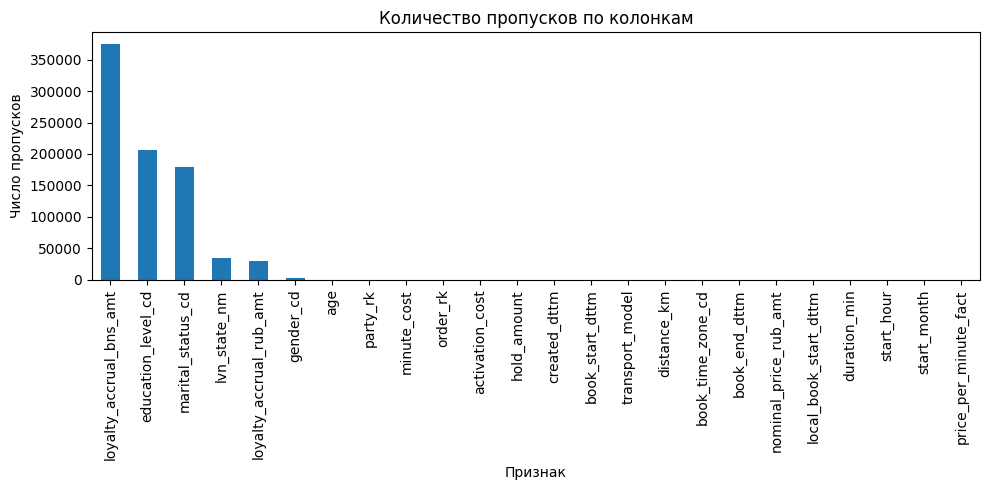

In [15]:

na_counts = df.isna().sum().sort_values(ascending=False)
display(na_counts.to_frame("missing_values"))

plt.figure(figsize=(10, 5))
na_counts.plot(kind="bar")
plt.title("Количество пропусков по колонкам")
plt.ylabel("Число пропусков")
plt.xlabel("Признак")
plt.tight_layout()
plt.show()


## 2) Количество потенциальных выбросов (1.5 IQR)

,outliers_count
book_time_zone_cd,96569
loyalty_accrual_rub_amt,40107
nominal_price_rub_amt,31417
duration_min,30569
distance_km,26495
price_per_minute_fact,17897
age,5678
loyalty_accrual_bns_amt,2752
minute_cost,65
hold_amount,31


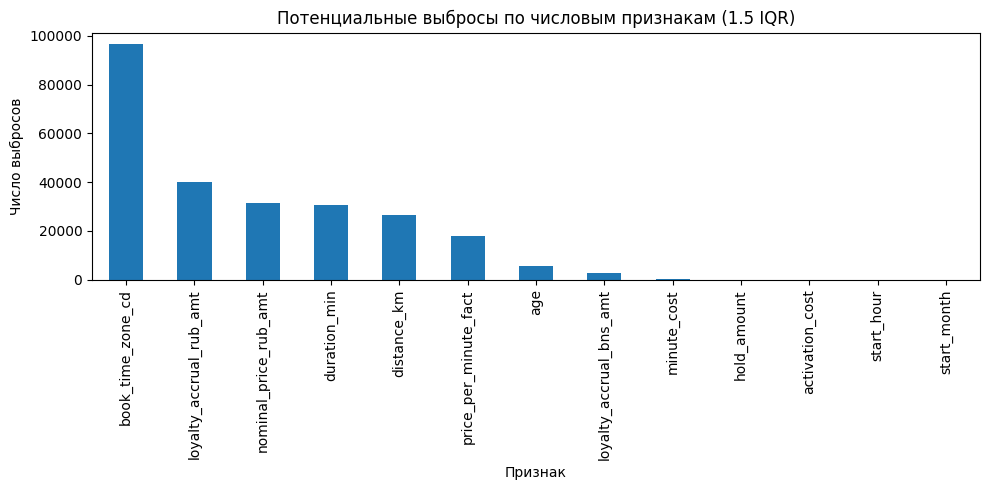

In [16]:

# Числовые колонки для анализа: исключим явные идентификаторы
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for bad in ["order_rk", "party_rk"]:
    if bad in numeric_cols:
        numeric_cols.remove(bad)

def iqr_outliers_count(s: pd.Series) -> int:
    s = s.dropna()
    if s.empty:
        return 0
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    return int(((s < low) | (s > high)).sum())

outlier_counts = {col: iqr_outliers_count(df[col]) for col in numeric_cols}
outlier_counts = pd.Series(outlier_counts).sort_values(ascending=False)
display(outlier_counts.to_frame("outliers_count"))

plt.figure(figsize=(10, 5))
outlier_counts.plot(kind="bar")
plt.title("Потенциальные выбросы по числовым признакам (1.5 IQR)")
plt.ylabel("Число выбросов")
plt.xlabel("Признак")
plt.tight_layout()
plt.show()


## 3) Корреляция между признаками (числовые)

,age,minute_cost,activation_cost,hold_amount,distance_km,book_time_zone_cd,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt,duration_min,start_hour,start_month,price_per_minute_fact
age,1.000000,0.062766,0.072271,-0.000606,0.001315,-0.078265,0.054268,0.023551,-0.000700,0.037409,-0.042933,-0.033289,0.014585
minute_cost,0.062766,1.000000,0.421931,0.028370,0.000978,-0.330214,0.170514,0.104838,0.027845,-0.039828,0.114810,0.223877,0.316788
activation_cost,0.072271,0.421931,1.000000,0.013746,0.000591,-0.474094,0.144487,0.064258,0.031168,-0.040622,0.037496,0.164523,0.348630
hold_amount,-0.000606,0.028370,0.013746,1.000000,0.000215,0.003474,0.006447,0.000518,0.000826,-0.002533,-0.001299,-0.002702,0.005930
distance_km,0.001315,0.000978,0.000591,0.000215,1.000000,-0.003100,0.020728,0.014564,0.053726,0.020510,-0.001355,-0.002810,-0.006945
book_time_zone_cd,-0.078265,-0.330214,-0.474094,0.003474,-0.003100,1.000000,-0.069111,-0.022318,0.008887,0.037034,0.027676,0.014554,-0.189500
nominal_price_rub_amt,0.054268,0.170514,0.144487,0.006447,0.020728,-0.069111,1.000000,0.690503,0.294205,0.954731,0.092391,0.012755,-0.272026
loyalty_accrual_rub_amt,0.023551,0.104838,0.064258,0.000518,0.014564,-0.022318,0.690503,1.000000,0.696930,0.653344,0.051409,0.117338,-0.160120
loyalty_accrual_bns_amt,-0.000700,0.027845,0.031168,0.000826,0.053726,0.008887,0.294205,0.696930,1.000000,0.314077,0.012920,-0.000524,-0.036329
duration_min,0.037409,-0.039828,-0.040622,-0.002533,0.020510,0.037034,0.954731,0.653344,0.314077,1.000000,0.076264,-0.043932,-0.390346


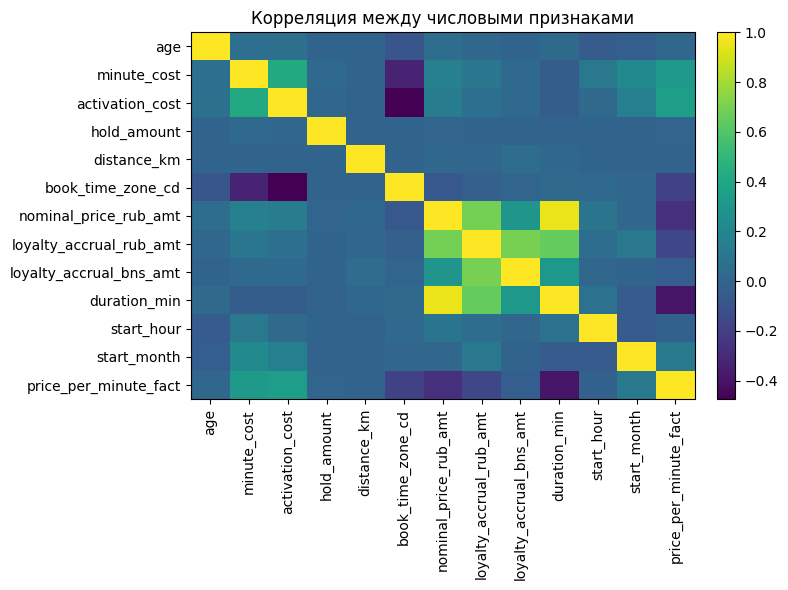

In [17]:

corr = df[numeric_cols].corr(numeric_only=True)
display(corr)

plt.figure(figsize=(8, 6))
im = plt.imshow(corr, aspect='auto')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Корреляция между числовыми признаками")
plt.tight_layout()
plt.show()


## 4) Длительность поездки (мин) — 0..100, шаг 5; среднее и математическое ожидание

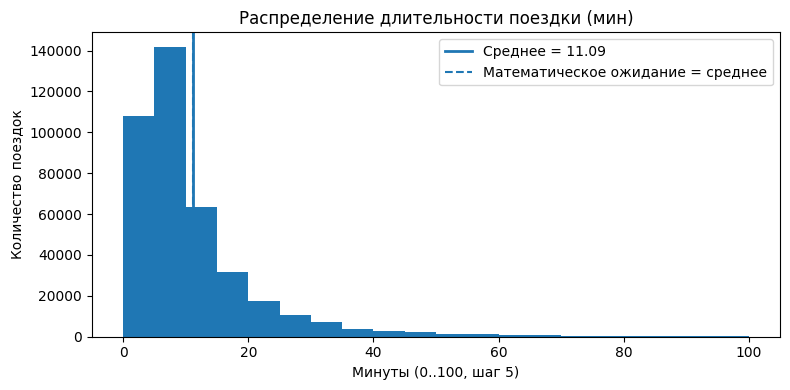

In [18]:

dur = df["duration_min"].dropna()
bins = np.arange(0, 100 + 5, 5)
mean_dur = dur[(dur >= 0) & (dur <= 100)].mean()

plt.figure(figsize=(8, 4))
plt.hist(dur[(dur >= 0) & (dur <= 100)], bins=bins)
plt.title("Распределение длительности поездки (мин)")
plt.xlabel("Минуты (0..100, шаг 5)")
plt.ylabel("Количество поездок")
# Среднее и мат. ожидание
if not np.isnan(mean_dur):
    plt.axvline(mean_dur, linestyle="solid", linewidth=2, label=f"Среднее = {mean_dur:.2f}")
    plt.axvline(mean_dur, linestyle="dashed", linewidth=1.5, label="Математическое ожидание = среднее")
plt.legend()
plt.tight_layout()
plt.show()


## 5) Количество поездок по часам старта (0–23)

,trips_count
start_hour,
0,2374
1,1864
2,2372
3,5923
4,15981
5,25528
6,20437
7,15726
8,14861


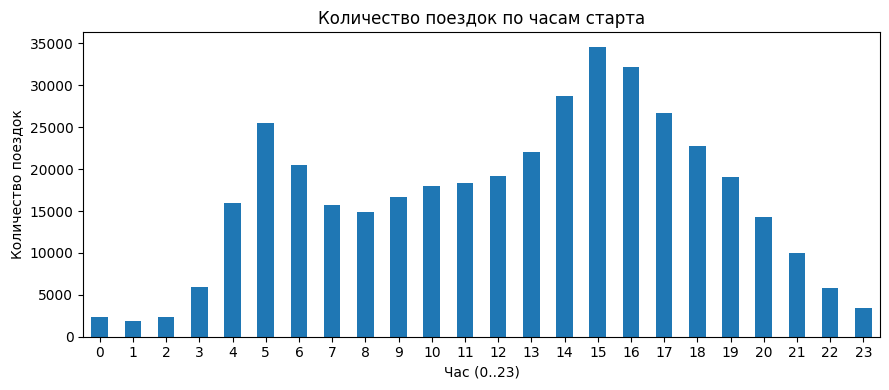

In [19]:

hours = df["start_hour"].dropna().astype(int)
counts_by_hour = hours.value_counts().reindex(range(24), fill_value=0).sort_index()
display(counts_by_hour.to_frame("trips_count"))

plt.figure(figsize=(9, 4))
counts_by_hour.plot(kind="bar")
plt.title("Количество поездок по часам старта")
plt.xlabel("Час (0..23)")
plt.ylabel("Количество поездок")
plt.xticks(range(24), range(0,24,1), rotation=0)
plt.xlim(-0.5, 23.5)
plt.tight_layout()
plt.show()


## 6) Количество поездок по месяцам

,month,trips_count
0,Апр,75
1,Май,4762
2,Июн,40295
3,Июл,80318
4,Авг,109583
5,Сен,115686
6,Окт,46030


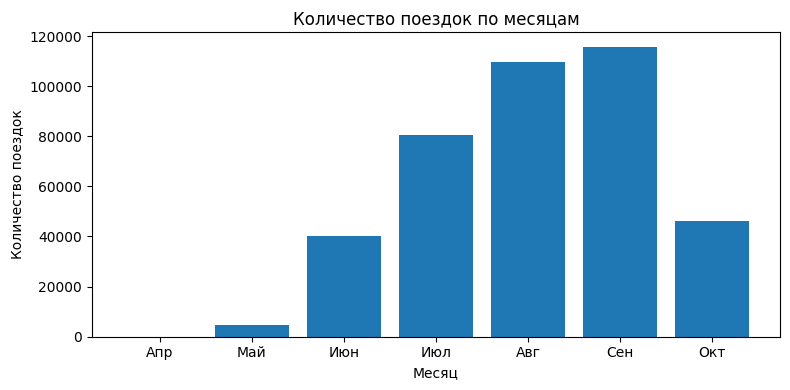

In [20]:


ru_months = {
    1: "Янв", 2: "Фев", 3: "Мар", 4: "Апр", 5: "Май", 6: "Июн",
    7: "Июл", 8: "Авг", 9: "Сен", 10: "Окт", 11: "Ноя", 12: "Дек"
}
months = df["start_month"].dropna().astype(int)
counts_by_month = months.value_counts().sort_index()
idx = sorted(counts_by_month.index.tolist())
labels = [ru_months.get(i, str(i)) for i in idx]
display(pd.DataFrame({"month": labels, "trips_count": counts_by_month.values}))

plt.figure(figsize=(8, 4))
plt.bar(range(len(idx)), counts_by_month.values)
plt.title("Количество поездок по месяцам")
plt.xlabel("Месяц")
plt.ylabel("Количество поездок")
plt.xticks(range(len(idx)), labels)
plt.tight_layout()
plt.show()


## 7) Средняя цена за минуту в зависимости от часа старта поездки

,avg_price_per_minute
start_hour,
0,7.135636
1,7.160129
2,7.245839
3,7.330915
4,6.824865
5,6.926653
6,6.978013
7,7.118242
8,7.090139


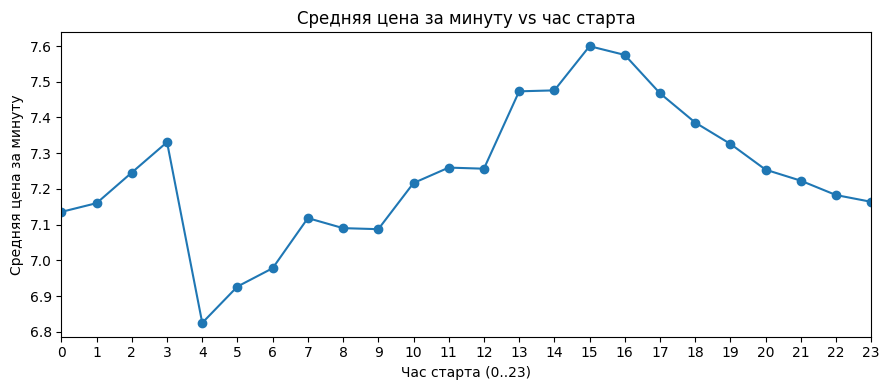

In [21]:


series_for_price = None
if "minute_cost" in df.columns:
    tmp = df.dropna(subset=["start_hour", "minute_cost"]).copy()
    tmp["start_hour"] = tmp["start_hour"].astype(int)
    mean_by_hour = tmp.groupby("start_hour")["minute_cost"].mean().reindex(range(24), fill_value=np.nan)
    series_for_price = mean_by_hour
else:

    tmp = df.dropna(subset=["start_hour", "price_per_minute_fact"]).copy()
    tmp = tmp[(tmp["price_per_minute_fact"] > 0) & (np.isfinite(tmp["price_per_minute_fact"]))]
    tmp["start_hour"] = tmp["start_hour"].astype(int)
    mean_by_hour = tmp.groupby("start_hour")["price_per_minute_fact"].mean().reindex(range(24), fill_value=np.nan)
    series_for_price = mean_by_hour

display(series_for_price.to_frame("avg_price_per_minute"))

plt.figure(figsize=(9, 4))
plt.plot(series_for_price.index, series_for_price.values, marker="o")
plt.title("Средняя цена за минуту vs час старта")
plt.xlabel("Час старта (0..23)")
plt.ylabel("Средняя цена за минуту")
plt.xticks(range(0,24,1))
plt.xlim(0,23)
plt.tight_layout()
plt.show()


## Таблица математического ожидания (среднего) для числовых признаков

In [22]:

numeric_cols_full = df.select_dtypes(include=[np.number]).columns.tolist()

for bad in ["order_rk", "party_rk"]:
    if bad in numeric_cols_full:
        numeric_cols_full.remove(bad)

means = df[numeric_cols_full].mean(numeric_only=True).sort_index()
means_df = means.reset_index()
means_df.columns = ["feature", "expected_value_mean"]
display(means_df)

means_df.to_csv("means_table.csv", index=False)
print("Сохранено: means_table.csv")


,feature,expected_value_mean
0,activation_cost,42.593226
1,age,31.544006
2,book_time_zone_cd,3.536155
3,distance_km,3.681031
4,duration_min,11.440989
5,hold_amount,299.983869
6,loyalty_accrual_bns_amt,127.789319
7,loyalty_accrual_rub_amt,37.516121
8,minute_cost,7.288688
9,nominal_price_rub_amt,127.647694


Сохранено: means_table.csv


/tmp/ipython-input-335338540.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_counts.index, y=gender_counts.values, palette="pastel")


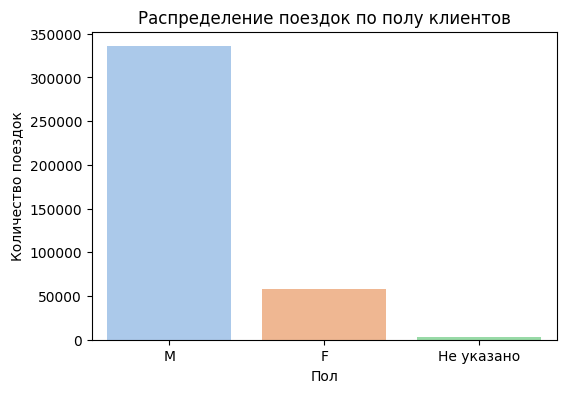

,trips_count
gender_cd,
M,335458
F,58370
Не указано,2921


In [23]:
import seaborn as sns

plt.figure(figsize=(6,4))
gender_counts = df['gender_cd'].value_counts(dropna=False)

# Для красоты подпишем NaN как "Не указано"
gender_counts.index = gender_counts.index.fillna("Не указано")

sns.barplot(x=gender_counts.index, y=gender_counts.values, palette="pastel")
plt.title("Распределение поездок по полу клиентов")
plt.xlabel("Пол")
plt.ylabel("Количество поездок")
plt.show()

display(gender_counts.to_frame("trips_count"))